In [1]:
import h5py
import numpy as np
from scipy.stats import norm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def gaussian(x, mu, sigma):
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x-mu)**2/(2*sigma**2))

In [3]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

In [4]:
def set_fontsize(ax, fs):
    ax.title.set_fontsize(fs*1.3)
    ax.xaxis.label.set_fontsize(fs)
    ax.yaxis.label.set_fontsize(fs)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs/1.25)

In [5]:
def check_switching_effect(fname, dset_name):
    # loading data from HDF file
    with h5py.File(fname, 'r') as f:
        laserlock = f[dset_name]['readout']['Laser Lock'][()]
        wavelength = f[dset_name]['readout']['Wavelength'][()]
        pxie = {}
        for dset in tqdm(f[dset_name]['readout']['PXIe-5171']):
            if 'events' not in dset:
                pxie[int(dset.split('_')[-1])] = f[dset_name]['readout']['PXIe-5171'][dset][()]
                
    # averaging data over same switching states, e.g. 5x shutter open -> average together
    switch_open = []
    switch_closed = []
    switch_state = pxie[1][:,2].mean() > 500
    data_temp = np.zeros(2000)
    switch_states = []
    for i in range(1,max(pxie.keys())+1):
        switch_states.append((pxie[i][:,2].mean() > 500))
        if switch_state == (pxie[i][:,2].mean() > 500):
            data_temp -= pxie[i][:,1] - pxie[i][:,1][50:250].mean()
        else:
            if switch_state == True:
                switch_open.append(data_temp)
            else:
                switch_closed.append(data_temp)
            switch_state = (pxie[i][:,2].mean() > 500)
            data_temp = -(pxie[i][:,1] - pxie[i][:,1][50:250].mean())
           
    # integrating averaged data with trapz
    integrated_switch_open = []
    integrated_switch_closed = []
    for data in switch_open:
        integrated_switch_open.append(np.trapz(data[250:1750]))
    for data in switch_closed:
        integrated_switch_closed.append(np.trapz(data[250:1750]))
        
    # calculating the ratio between switching states
    ratio = []
    for i_open, i_close in zip(integrated_switch_open, integrated_switch_closed):
        ratio.append(i_open/i_close)
        
    return switch_open, switch_closed, integrated_switch_open, integrated_switch_closed, ratio, switch_states, laserlock, wavelength

In [6]:
fname = "rotation_cooling.hdf"

# Switching rotational cooling light

Switching the rotational cooling light on/off with a shutter, shutter state is captured in CH2 of the PXIe-5171 data acquisition. 

| high| low | 
|-----|-----|
|open|closed|

PMT is set to 1kV, 2x factor 5 amplificationstages on SRS amplifier.  

PXIe-5171 Channels

|ch0  |ch1    |ch2    |
|------|------|------|
|trigger  |PMT | polarization or light state|

## R0 F2 detection, P2 F1 rotational cooling

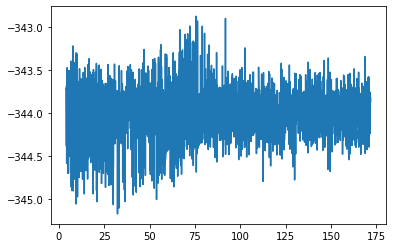

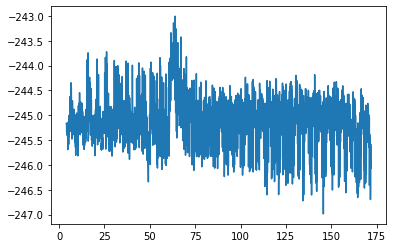

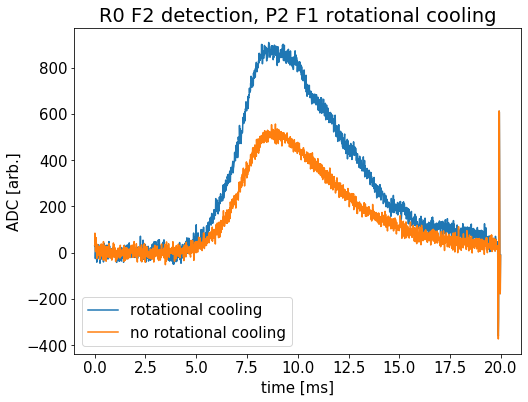

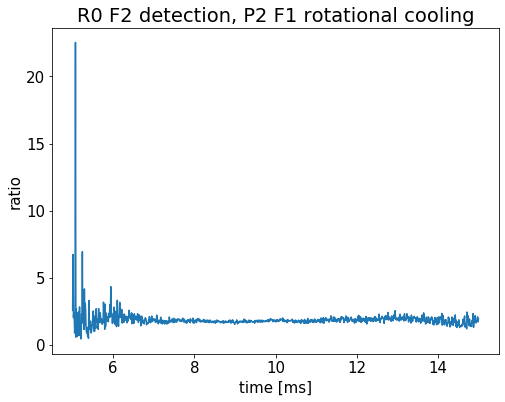

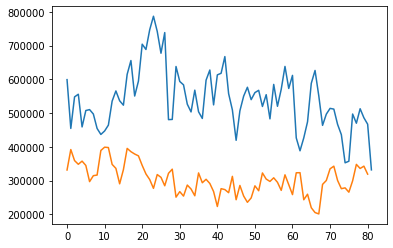

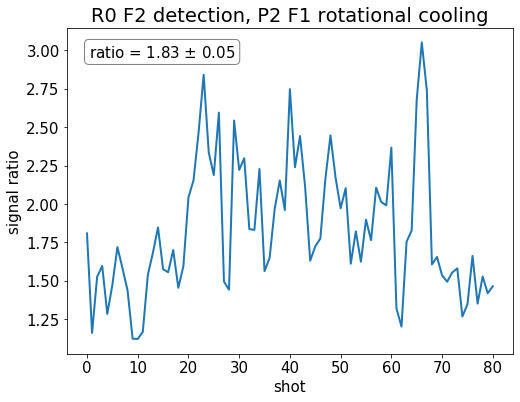

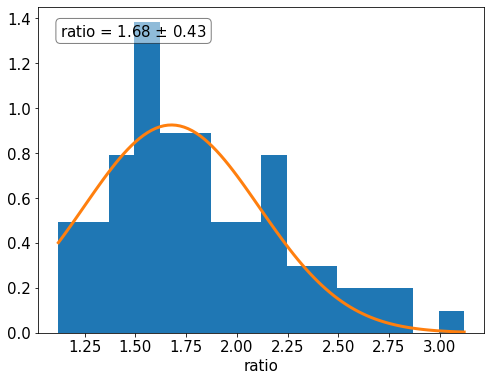

In [7]:
dset_name = "1582245525 switching_rot_cooling_light_P2_F1_detection_R0_F2"
shutter_open, shutter_closed, integrated_shutter_open, integrated_shutter_closed, ratio, switch_states, laserlock, wavelength = check_switching_effect(fname, dset_name)

title = "R0 F2 detection, P2 F1 rotational cooling"
filename = 'switch_cooling_light_'+title

t = np.arange(0,20,1/(1e2))

plt.figure()
plt.plot(laserlock['time'], laserlock['laser 1 frequency'])
plt.figure()
plt.plot(laserlock['time'], laserlock['laser 2 frequency'])

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(t, np.mean(shutter_open, axis = 0), label = 'rotational cooling')
ax.plot(t, np.mean(shutter_closed, axis = 0), label = 'no rotational cooling')

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ADC [arb.]')

ax.legend(fontsize = 15)
set_fontsize(ax, 15)
fig.savefig(filename+'_signal.png', dpi = 300)

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(t[500:1500], (np.mean(shutter_open, axis = 0)/np.mean(shutter_closed, axis = 0))[500:1500])

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ratio')

set_fontsize(ax, 15)

plt.figure()
plt.plot(integrated_shutter_open)
plt.plot(integrated_shutter_closed)

# excluding ratios larger than 10, clearly some noisy data there
ratio = np.array(ratio)
ratio = ratio[(ratio < 10) & (ratio > 0)]

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(ratio, lw = 2)

textstr = f"ratio = {np.mean(ratio):.2f} $\pm$ {np.std(ratio)/np.sqrt(ratio.size):.2f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

ax.set_title(title)
ax.set_xlabel('shot')
ax.set_ylabel('signal ratio')
set_fontsize(ax, 15)
fig.savefig(filename+'_ratio.png', dpi = 300)

bins = np.arange(ratio.min(), ratio.max()+1/8, 1/8)
fig, ax = plt.subplots(figsize = (8,6))
n, bins, _ = ax.hist(ratio, bins = bins, density = True, histtype='bar')
popt, pcov = curve_fit(gaussian, bins[:-1]+(bins[1]-bins[0])/2, n, p0 = (np.mean(ratio), np.std(ratio)))

ax.plot(np.linspace(bins.min(), bins.max(), 101), gaussian(np.linspace(bins.min(), bins.max(), 101), *popt),
        lw = 3)
ax.set_xlabel('ratio')
set_fontsize(ax, 15)
textstr = f"ratio = {popt[0]:.2f} $\pm$ {popt[1]:.2f}"
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props);

## R0 F2 detection, P2 F2 rotational cooling

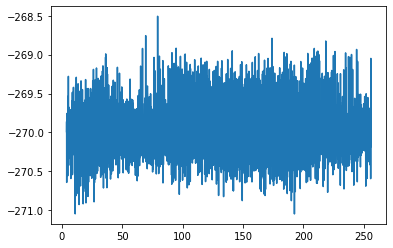

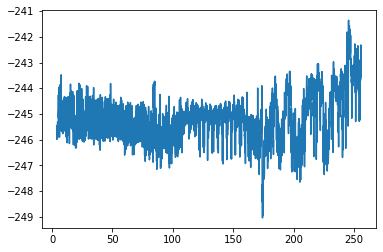

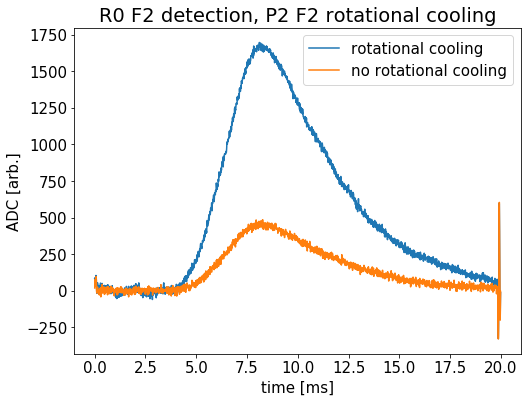

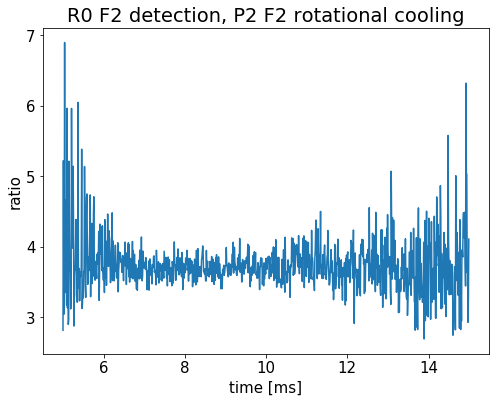

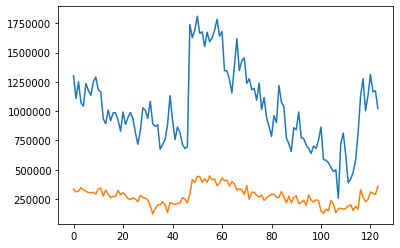

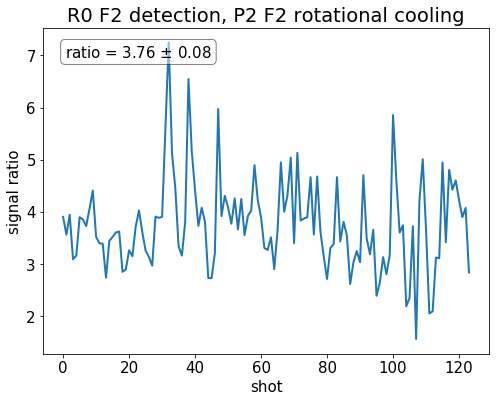

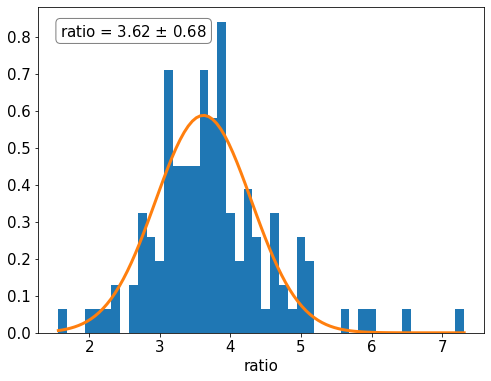

In [8]:
dset_name = '1582246085 check_effect_pol_switching_light_P2_F2_detection_R0_F2'
shutter_open, shutter_closed, integrated_shutter_open, integrated_shutter_closed, ratio, switch_states, laserlock, wavelength = check_switching_effect(fname, dset_name)

title = "R0 F2 detection, P2 F2 rotational cooling"
filename = 'switch_cooling_light_'+title

t = np.arange(0,20,1/(1e2))

plt.figure()
plt.plot(laserlock['time'], laserlock['laser 1 frequency'])
plt.figure()
plt.plot(laserlock['time'], laserlock['laser 2 frequency'])

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(t, np.mean(shutter_open, axis = 0), label = 'rotational cooling')
ax.plot(t, np.mean(shutter_closed, axis = 0), label = 'no rotational cooling')

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ADC [arb.]')

ax.legend(fontsize = 15)
set_fontsize(ax, 15)
fig.savefig(filename+'_signal.png', dpi = 300)

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(t[500:1500], (np.mean(shutter_open, axis = 0)/np.mean(shutter_closed, axis = 0))[500:1500])

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ratio')

set_fontsize(ax, 15)

plt.figure()
plt.plot(integrated_shutter_open)
plt.plot(integrated_shutter_closed)

# excluding ratios larger than 10, clearly some noisy data there
ratio = np.array(ratio)
ratio = ratio[(ratio < 10) & (ratio > 0)]

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(ratio, lw = 2)

textstr = f"ratio = {np.mean(ratio):.2f} $\pm$ {np.std(ratio)/np.sqrt(ratio.size):.2f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

ax.set_title(title)
ax.set_xlabel('shot')
ax.set_ylabel('signal ratio')
set_fontsize(ax, 15)
fig.savefig(filename+'_ratio.png', dpi = 300)

bins = np.arange(ratio.min(), ratio.max()+1/8, 1/8)
fig, ax = plt.subplots(figsize = (8,6))
n, bins, _ = ax.hist(ratio, bins = bins, density = True, histtype='bar')
popt, pcov = curve_fit(gaussian, bins[:-1]+(bins[1]-bins[0])/2, n, p0 = (np.mean(ratio), np.std(ratio)))

ax.plot(np.linspace(bins.min(), bins.max(), 101), gaussian(np.linspace(bins.min(), bins.max(), 101), *popt),
        lw = 3)
ax.set_xlabel('ratio')
set_fontsize(ax, 15)
textstr = f"ratio = {popt[0]:.2f} $\pm$ {popt[1]:.2f}"
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props);

## R0 F1 detection, P2 F2 rotational cooling

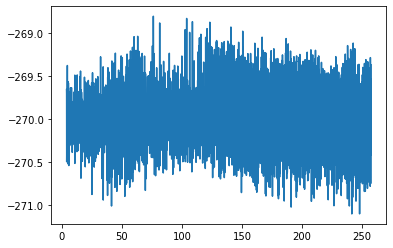

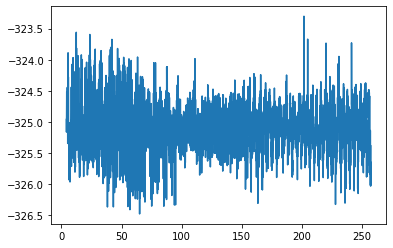

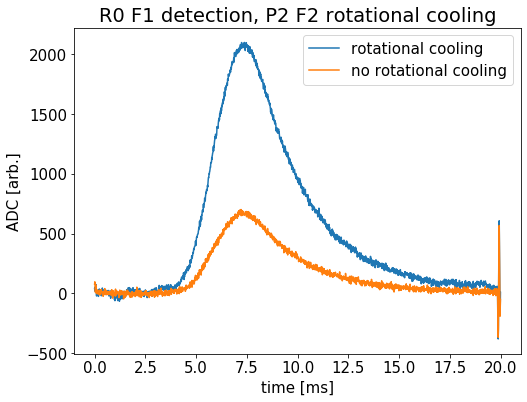

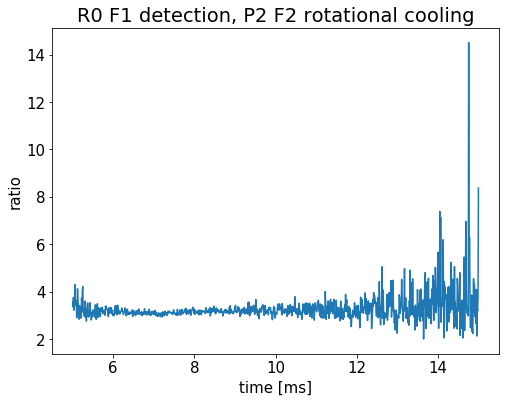

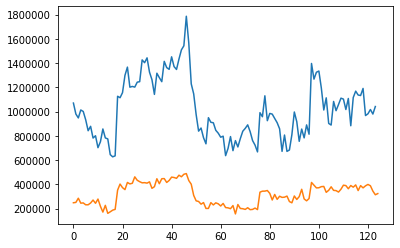

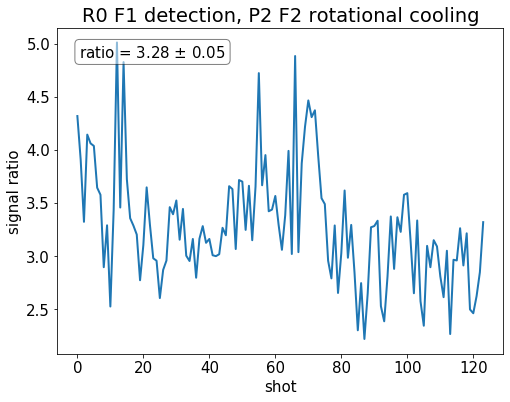

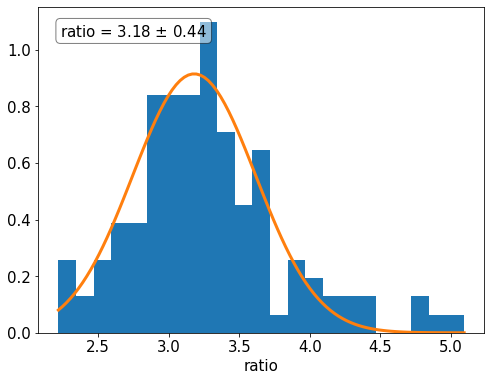

In [9]:
dset_name = '1582246569 check_pol_switching_light_P2_F2_detection_R0_F1'
shutter_open, shutter_closed, integrated_shutter_open, integrated_shutter_closed, ratio, switch_states, laserlock, wavelength = check_switching_effect(fname, dset_name)

title = "R0 F1 detection, P2 F2 rotational cooling"
filename = 'switch_cooling_light_'+title

t = np.arange(0,20,1/(1e2))

plt.figure()
plt.plot(laserlock['time'], laserlock['laser 1 frequency'])
plt.figure()
plt.plot(laserlock['time'], laserlock['laser 2 frequency'])

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(t, np.mean(shutter_open, axis = 0), label = 'rotational cooling')
ax.plot(t, np.mean(shutter_closed, axis = 0), label = 'no rotational cooling')

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ADC [arb.]')

ax.legend(fontsize = 15)
set_fontsize(ax, 15)
fig.savefig(filename+'_signal.png', dpi = 300)

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(t[500:1500], (np.mean(shutter_open, axis = 0)/np.mean(shutter_closed, axis = 0))[500:1500])

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ratio')

set_fontsize(ax, 15)

plt.figure()
plt.plot(integrated_shutter_open)
plt.plot(integrated_shutter_closed)

# excluding ratios larger than 10, clearly some noisy data there
ratio = np.array(ratio)
ratio = ratio[(ratio < 10) & (ratio > 0)]

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(ratio, lw = 2)

textstr = f"ratio = {np.mean(ratio):.2f} $\pm$ {np.std(ratio)/np.sqrt(ratio.size):.2f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

ax.set_title(title)
ax.set_xlabel('shot')
ax.set_ylabel('signal ratio')
set_fontsize(ax, 15)
fig.savefig(filename+'_ratio.png', dpi = 300)

bins = np.arange(ratio.min(), ratio.max()+1/8, 1/8)
fig, ax = plt.subplots(figsize = (8,6))
n, bins, _ = ax.hist(ratio, bins = bins, density = True, histtype='bar')
popt, pcov = curve_fit(gaussian, bins[:-1]+(bins[1]-bins[0])/2, n, p0 = (np.mean(ratio), np.std(ratio)))

ax.plot(np.linspace(bins.min(), bins.max(), 101), gaussian(np.linspace(bins.min(), bins.max(), 101), *popt),
        lw = 3)
ax.set_xlabel('ratio')
set_fontsize(ax, 15)
textstr = f"ratio = {popt[0]:.2f} $\pm$ {popt[1]:.2f}"
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props);

## R0 F1 detection, P2 F1 rotational cooling

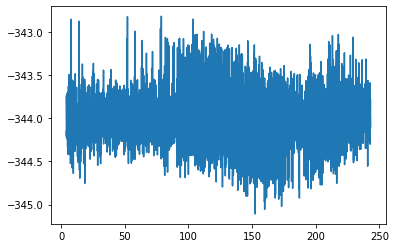

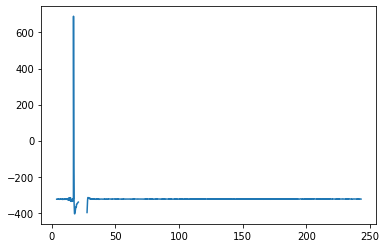

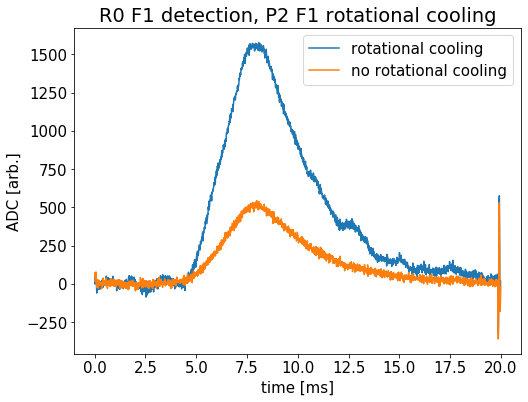

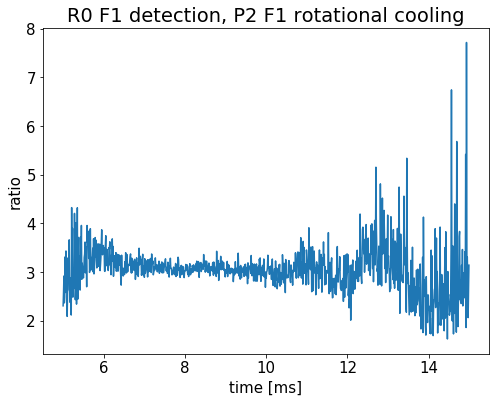

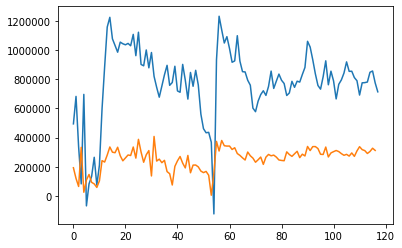

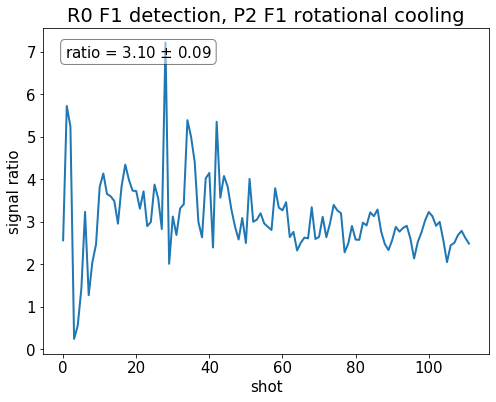

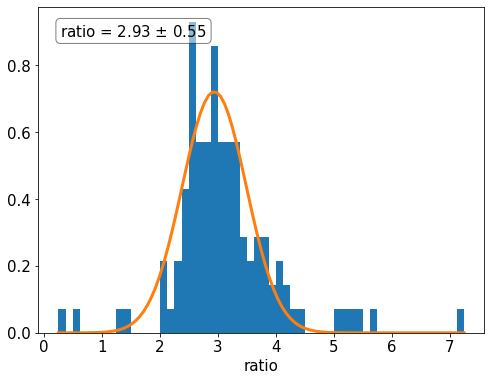

In [10]:
dset_name = '1582244846 switch_light_cooling_P2_F1'
shutter_open, shutter_closed, integrated_shutter_open, integrated_shutter_closed, ratio, switch_states, laserlock, wavelength = check_switching_effect(fname, dset_name)

title = "R0 F1 detection, P2 F1 rotational cooling"
filename = 'switch_cooling_light_'+title

t = np.arange(0,20,1/(1e2))

plt.figure()
plt.plot(laserlock['time'], laserlock['laser 1 frequency'])
plt.figure()
plt.plot(laserlock['time'], laserlock['laser 2 frequency'])

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(t, np.mean(shutter_open, axis = 0), label = 'rotational cooling')
ax.plot(t, np.mean(shutter_closed, axis = 0), label = 'no rotational cooling')

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ADC [arb.]')

ax.legend(fontsize = 15)
set_fontsize(ax, 15)
fig.savefig(filename+'_signal.png', dpi = 300)

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(t[500:1500], (np.mean(shutter_open, axis = 0)/np.mean(shutter_closed, axis = 0))[500:1500])

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ratio')

set_fontsize(ax, 15)

plt.figure()
plt.plot(integrated_shutter_open)
plt.plot(integrated_shutter_closed)

# excluding ratios larger than 10, clearly some noisy data there
ratio = np.array(ratio)
ratio = ratio[(ratio < 10) & (ratio > 0)]

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(ratio, lw = 2)

textstr = f"ratio = {np.mean(ratio):.2f} $\pm$ {np.std(ratio)/np.sqrt(ratio.size):.2f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

ax.set_title(title)
ax.set_xlabel('shot')
ax.set_ylabel('signal ratio')
set_fontsize(ax, 15)
fig.savefig(filename+'_ratio.png', dpi = 300)

bins = np.arange(ratio.min(), ratio.max()+1/8, 1/8)
fig, ax = plt.subplots(figsize = (8,6))
n, bins, _ = ax.hist(ratio, bins = bins, density = True, histtype='bar')
popt, pcov = curve_fit(gaussian, bins[:-1]+(bins[1]-bins[0])/2, n, p0 = (np.mean(ratio), np.std(ratio)))

ax.plot(np.linspace(bins.min(), bins.max(), 101), gaussian(np.linspace(bins.min(), bins.max(), 101), *popt),
        lw = 3)
ax.set_xlabel('ratio')
set_fontsize(ax, 15)
textstr = f"ratio = {popt[0]:.2f} $\pm$ {popt[1]:.2f}"
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props);

# Detection polarization switching

Switching the detection polarization switching on/off with the function generator aux input. Polarization switching state is captured in CH2 of the PXIe-5171 data acquisition. 

| high| low | 
|-----|-----|
|pol switching|no switching|

PMT is set to 1kV, 2x factor 5 amplificationstages on SRS amplifier.  

PXIe-5171 Channels

|ch0  |ch1    |ch2    |
|------|------|------|
|trigger  |PMT | polarization or light state|

## R0 F1 detection, P2 F2 rotational cooling

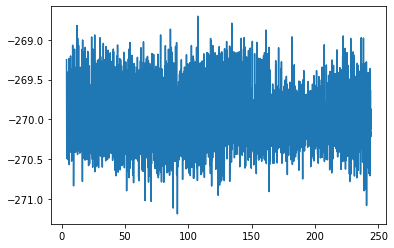

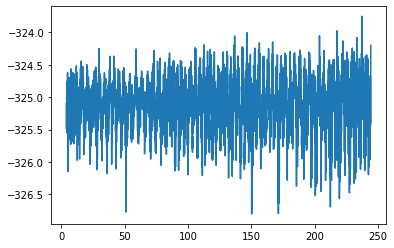

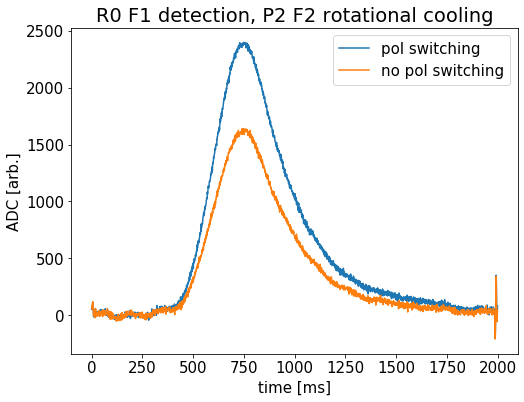

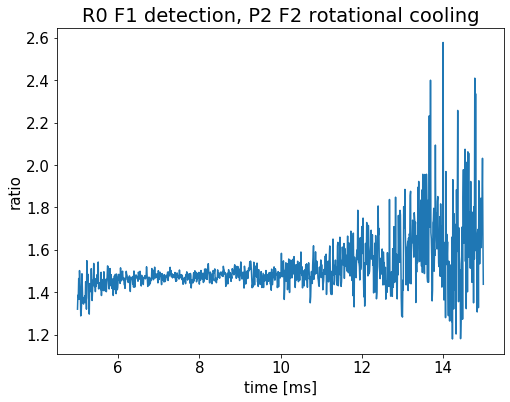

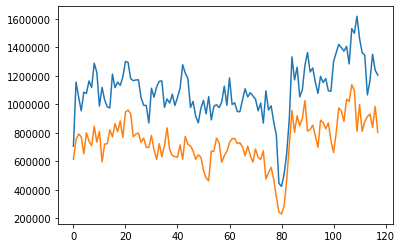

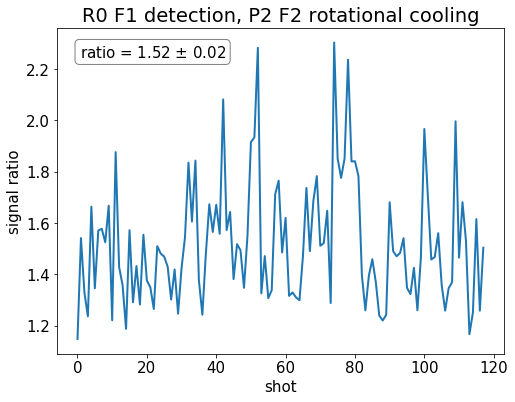

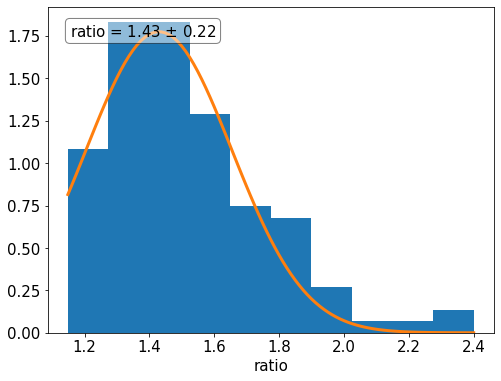

In [11]:
dset_name = "1582247278 check_pol_switching_det_light_rot_cooling_P2_F2_detection_R0_F1"
switch_open, switch_closed, integrated_switch_open, integrated_switch_closed, ratio, switch_states, laserlock, wavelength = check_switching_effect(fname, dset_name)

title = "R0 F1 detection, P2 F2 rotational cooling"
filename = 'switch_detection_polarization'+title

plt.figure()
plt.plot(laserlock['time'], laserlock['laser 1 frequency'])
plt.figure()
plt.plot(laserlock['time'], laserlock['laser 2 frequency'])

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(np.mean(switch_open, axis = 0), label = 'pol switching')
ax.plot(np.mean(switch_closed, axis = 0), label = 'no pol switching')

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ADC [arb.]')

ax.legend(fontsize = 15)
set_fontsize(ax, 15)
fig.savefig(filename+'_signal.png', dpi = 300)

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(t[500:1500], (np.mean(switch_open, axis = 0)/np.mean(switch_closed, axis = 0))[500:1500])

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ratio')

set_fontsize(ax, 15)

plt.figure()
plt.plot(integrated_switch_open)
plt.plot(integrated_switch_closed)

# excluding ratios larger than 10, clearly some noisy data there
ratio = np.array(ratio)
ratio = ratio[(ratio < 10) & (ratio > 0)]

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(ratio, lw = 2)

textstr = f"ratio = {np.mean(ratio):.2f} $\pm$ {np.std(ratio)/np.sqrt(ratio.size):.2f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

ax.set_title(title)
ax.set_xlabel('shot')
ax.set_ylabel('signal ratio')
set_fontsize(ax, 15)
fig.savefig(filename+'_ratio.png', dpi = 300)

bins = np.arange(ratio.min(), ratio.max()+1/8, 1/8)
fig, ax = plt.subplots(figsize = (8,6))
n, bins, _ = ax.hist(ratio, bins = bins, density = True, histtype='bar')
popt, pcov = curve_fit(gaussian, bins[:-1]+(bins[1]-bins[0])/2, n, p0 = (np.mean(ratio), np.std(ratio)))

ax.plot(np.linspace(bins.min(), bins.max(), 101), gaussian(np.linspace(bins.min(), bins.max(), 101), *popt),
        lw = 3)
ax.set_xlabel('ratio')
set_fontsize(ax, 15)
textstr = f"ratio = {popt[0]:.2f} $\pm$ {popt[1]:.2f}"
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props);

# Rotational cooling polarization switching

Switching the rotational cooling polarization switching on/off with the function generator aux input. Polarization switching state is captured in CH2 of the PXIe-5171 data acquisition. 

| high| low | 
|-----|-----|
|pol switching|no switching|

PMT is set to 1kV, 2x factor 5 amplificationstages on SRS amplifier.  

PXIe-5171 Channels

|ch0  |ch1    |ch2    |
|------|------|------|
|trigger  |PMT | polarization or light state|

## R0 F1 detection, P2 F2 rotational cooling

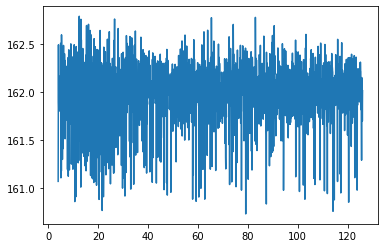

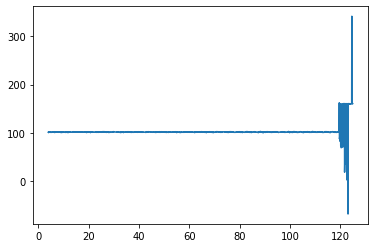

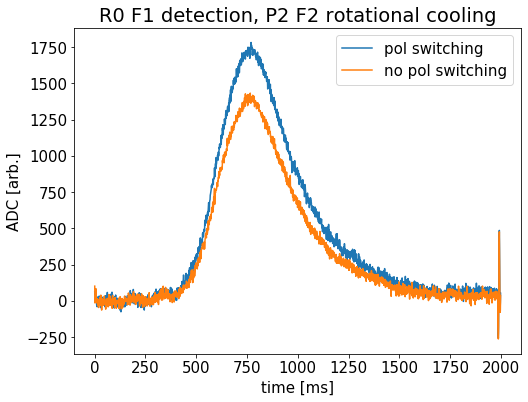

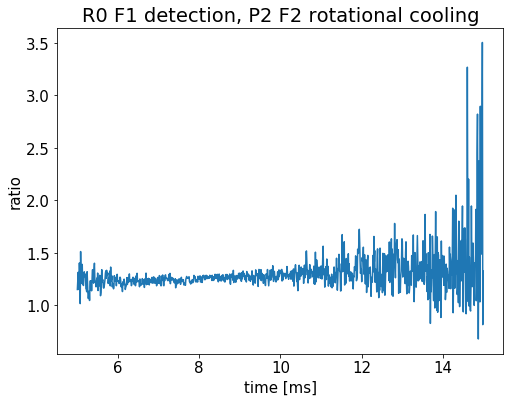

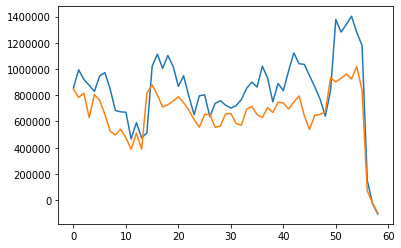

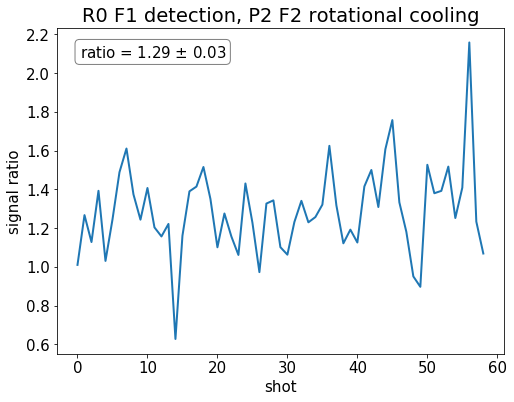

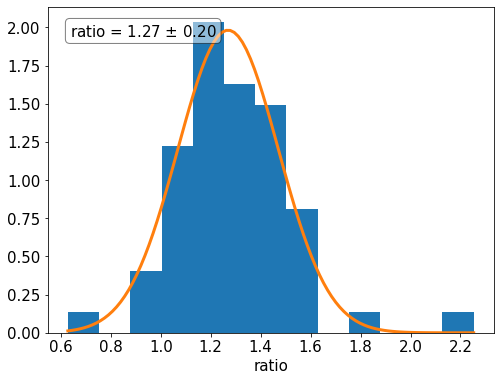

In [12]:
dset_name = "1582239154 check_effect_pol_switching_rot_cooling_peak_P2_F2"
switch_open, switch_closed, integrated_switch_open, integrated_switch_closed, ratio, switch_states, laserlock, wavelength = check_switching_effect(fname, dset_name)

title = "R0 F1 detection, P2 F2 rotational cooling"
filename = 'switch_rotational_cooling_polarization'+title

plt.figure()
plt.plot(laserlock['time'], laserlock['laser 1 frequency'])
plt.figure()
plt.plot(laserlock['time'], laserlock['laser 2 frequency'])

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(np.mean(switch_open, axis = 0), label = 'pol switching')
ax.plot(np.mean(switch_closed, axis = 0), label = 'no pol switching')

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ADC [arb.]')

ax.legend(fontsize = 15)
set_fontsize(ax, 15)
fig.savefig(filename+'_signal.png', dpi = 300)

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(t[500:1500], (np.mean(switch_open, axis = 0)/np.mean(switch_closed, axis = 0))[500:1500])

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ratio')

set_fontsize(ax, 15)

plt.figure()
plt.plot(integrated_switch_open)
plt.plot(integrated_switch_closed)

# excluding ratios larger than 10, clearly some noisy data there
ratio = np.array(ratio)
ratio = ratio[(ratio < 10) & (ratio > 0)]

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(ratio, lw = 2)

textstr = f"ratio = {np.mean(ratio):.2f} $\pm$ {np.std(ratio)/np.sqrt(ratio.size):.2f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

ax.set_title(title)
ax.set_xlabel('shot')
ax.set_ylabel('signal ratio')
set_fontsize(ax, 15)
fig.savefig(filename+'_ratio.png', dpi = 300)

bins = np.arange(ratio.min(), ratio.max()+1/8, 1/8)
fig, ax = plt.subplots(figsize = (8,6))
n, bins, _ = ax.hist(ratio, bins = bins, density = True, histtype='bar')
popt, pcov = curve_fit(gaussian, bins[:-1]+(bins[1]-bins[0])/2, n, p0 = (np.mean(ratio), np.std(ratio)))

ax.plot(np.linspace(bins.min(), bins.max(), 101), gaussian(np.linspace(bins.min(), bins.max(), 101), *popt),
        lw = 3)
ax.set_xlabel('ratio')
set_fontsize(ax, 15)
textstr = f"ratio = {popt[0]:.2f} $\pm$ {popt[1]:.2f}"
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props);

## R0 F1 detection, P2 F1 rotational cooling

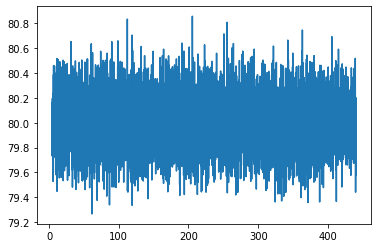

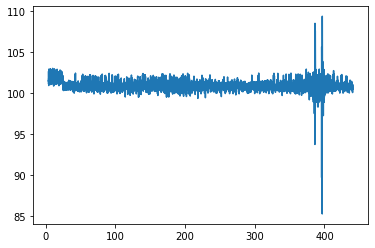

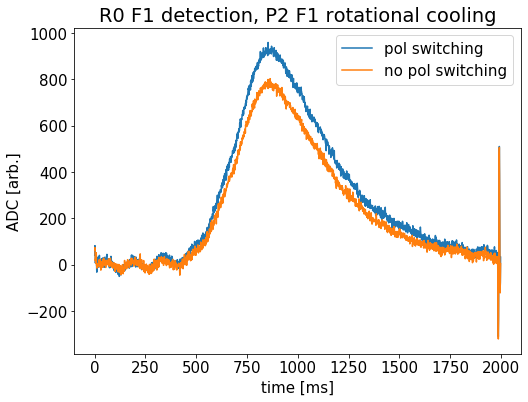

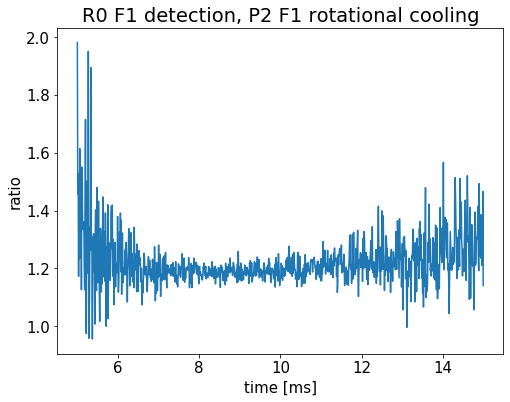

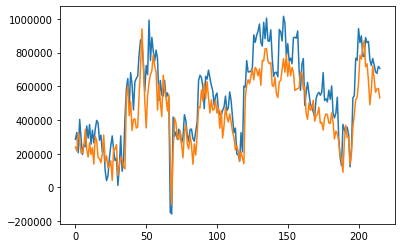

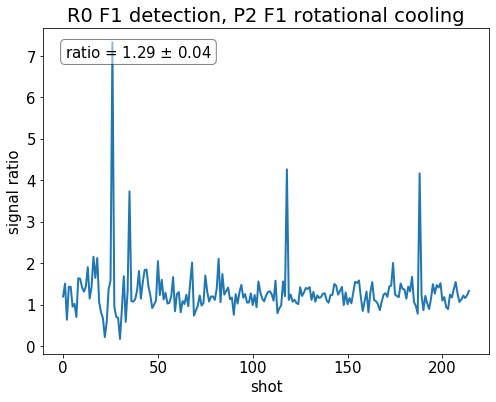

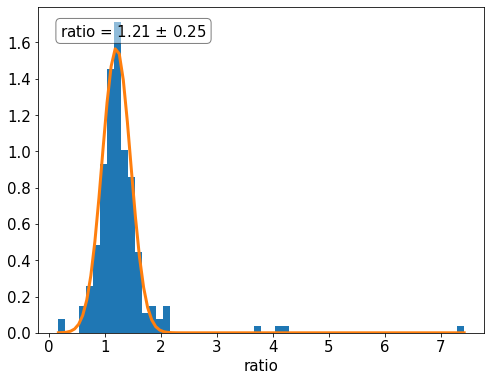

In [13]:
dset_name = "1582239993 check_effect_pol_switching_rot_cooling_peak_P2_F1"
switch_open, switch_closed, integrated_switch_open, integrated_switch_closed, ratio, switch_states, laserlock, wavelength = check_switching_effect(fname, dset_name)

title = "R0 F1 detection, P2 F1 rotational cooling"
filename = 'switch_rotational_cooling_polarization'+title

plt.figure()
plt.plot(laserlock['time'], laserlock['laser 1 frequency'])
plt.figure()
plt.plot(laserlock['time'], laserlock['laser 2 frequency'])

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(np.mean(switch_open, axis = 0), label = 'pol switching')
ax.plot(np.mean(switch_closed, axis = 0), label = 'no pol switching')

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ADC [arb.]')

ax.legend(fontsize = 15)
set_fontsize(ax, 15)
fig.savefig(filename+'_signal.png', dpi = 300)

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(t[500:1500], (np.mean(switch_open, axis = 0)/np.mean(switch_closed, axis = 0))[500:1500])

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ratio')

set_fontsize(ax, 15)

plt.figure()
plt.plot(integrated_switch_open)
plt.plot(integrated_switch_closed)

# excluding ratios larger than 10, clearly some noisy data there
ratio = np.array(ratio)
ratio = ratio[(ratio < 10) & (ratio > 0)]

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(ratio, lw = 2)

textstr = f"ratio = {np.mean(ratio):.2f} $\pm$ {np.std(ratio)/np.sqrt(ratio.size):.2f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

ax.set_title(title)
ax.set_xlabel('shot')
ax.set_ylabel('signal ratio')
set_fontsize(ax, 15)
fig.savefig(filename+'_ratio.png', dpi = 300)

bins = np.arange(ratio.min(), ratio.max()+1/8, 1/8)
fig, ax = plt.subplots(figsize = (8,6))
n, bins, _ = ax.hist(ratio, bins = bins, density = True, histtype='bar')
popt, pcov = curve_fit(gaussian, bins[:-1]+(bins[1]-bins[0])/2, n, p0 = (np.mean(ratio), np.std(ratio)))

ax.plot(np.linspace(bins.min(), bins.max(), 101), gaussian(np.linspace(bins.min(), bins.max(), 101), *popt),
        lw = 3)
ax.set_xlabel('ratio')
set_fontsize(ax, 15)
textstr = f"ratio = {popt[0]:.2f} $\pm$ {popt[1]:.2f}"
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props);

## R0 F1 detection, P2 F2 rotational cooling

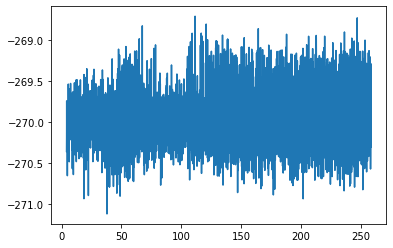

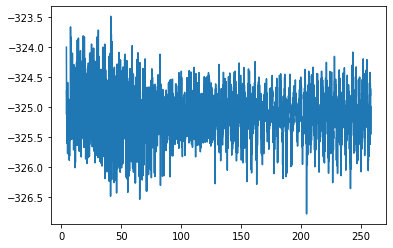

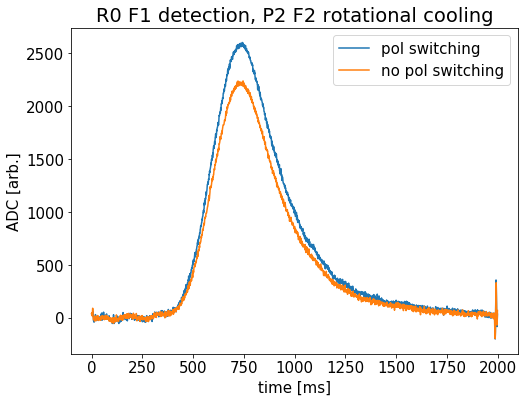

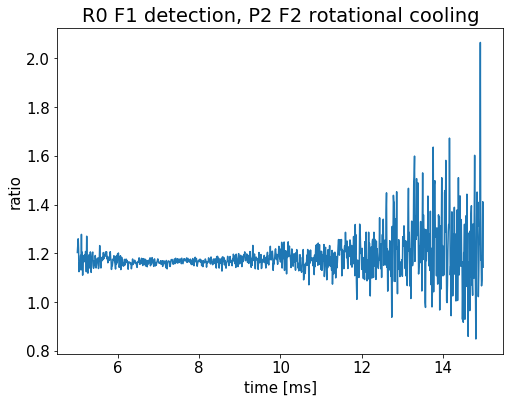

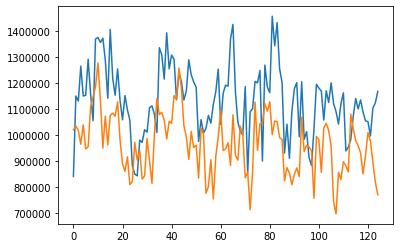

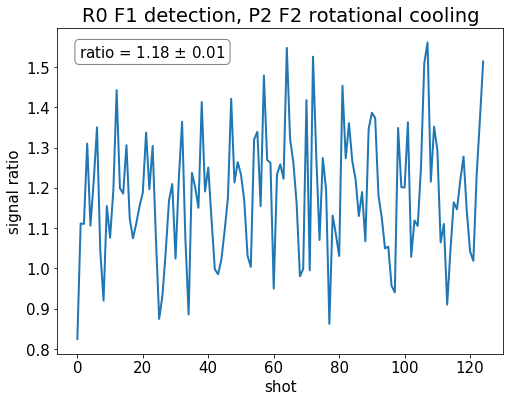

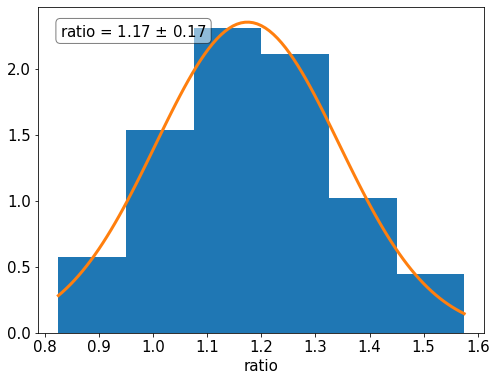

In [14]:
dset_name = '1582247702 check_pol_switching_rot_cooling_light_rot_cooling_P2_F2_detection_R0_F1'
switch_open, switch_closed, integrated_switch_open, integrated_switch_closed, ratio, switch_states, laserlock, wavelength = check_switching_effect(fname, dset_name)

title = "R0 F1 detection, P2 F2 rotational cooling"
filename = 'switch_rotational_cooling_polarization'+title

plt.figure()
plt.plot(laserlock['time'], laserlock['laser 1 frequency'])
plt.figure()
plt.plot(laserlock['time'], laserlock['laser 2 frequency'])

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(np.mean(switch_open, axis = 0), label = 'pol switching')
ax.plot(np.mean(switch_closed, axis = 0), label = 'no pol switching')

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ADC [arb.]')

ax.legend(fontsize = 15)
set_fontsize(ax, 15)
fig.savefig(filename+'_signal.png', dpi = 300)

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(t[500:1500], (np.mean(switch_open, axis = 0)/np.mean(switch_closed, axis = 0))[500:1500])

ax.set_title(title)
ax.set_xlabel('time [ms]')
ax.set_ylabel('ratio')

set_fontsize(ax, 15)

plt.figure()
plt.plot(integrated_switch_open)
plt.plot(integrated_switch_closed)

# excluding ratios larger than 10, clearly some noisy data there
ratio = np.array(ratio)
ratio = ratio[(ratio < 10) & (ratio > 0)]

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(ratio, lw = 2)

textstr = f"ratio = {np.mean(ratio):.2f} $\pm$ {np.std(ratio)/np.sqrt(ratio.size):.2f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

ax.set_title(title)
ax.set_xlabel('shot')
ax.set_ylabel('signal ratio')
set_fontsize(ax, 15)
fig.savefig(filename+'_ratio.png', dpi = 300)


bins = np.arange(ratio.min(), ratio.max()+1/8, 1/8)
fig, ax = plt.subplots(figsize = (8,6))
n, bins, _ = ax.hist(ratio, bins = bins, density = True, histtype='bar')
popt, pcov = curve_fit(gaussian, bins[:-1]+(bins[1]-bins[0])/2, n, p0 = (np.mean(ratio), np.std(ratio)))

ax.plot(np.linspace(bins.min(), bins.max(), 101), gaussian(np.linspace(bins.min(), bins.max(), 101), *popt),
        lw = 3)
ax.set_xlabel('ratio')
set_fontsize(ax, 15)
textstr = f"ratio = {popt[0]:.2f} $\pm$ {popt[1]:.2f}"
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props);